<a href="https://colab.research.google.com/github/qingchen815/CruiseFetchLite/blob/main/sensitivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def parse_result_file(file_path):
    # Parse ChampSim result file and extract key performance metrics
    data = {}

    with open(file_path, 'r') as f:
        content = f.read()

    # Extract IPC value
    ipc_match = re.search(r'CPU 0 cumulative IPC: (\d+\.\d+)', content)
    if ipc_match:
        data['IPC'] = float(ipc_match.group(1))

    # Extract L1D statistics
    l1d_access = re.search(r'L1D TOTAL\s+ACCESS:\s+(\d+)', content)
    l1d_hit = re.search(r'L1D TOTAL\s+ACCESS:\s+\d+\s+HIT:\s+(\d+)', content)
    l1d_miss = re.search(r'L1D TOTAL\s+ACCESS:\s+\d+\s+HIT:\s+\d+\s+MISS:\s+(\d+)', content)

    if l1d_access and l1d_hit and l1d_miss:
        data['L1D_ACCESS'] = int(l1d_access.group(1))
        data['L1D_HIT'] = int(l1d_hit.group(1))
        data['L1D_MISS'] = int(l1d_miss.group(1))
        data['L1D_HIT_RATE'] = data['L1D_HIT'] / data['L1D_ACCESS']

    # Extract L2C statistics
    l2c_access = re.search(r'L2C TOTAL\s+ACCESS:\s+(\d+)', content)
    l2c_hit = re.search(r'L2C TOTAL\s+ACCESS:\s+\d+\s+HIT:\s+(\d+)', content)
    l2c_miss = re.search(r'L2C TOTAL\s+ACCESS:\s+\d+\s+HIT:\s+\d+\s+MISS:\s+(\d+)', content)

    if l2c_access and l2c_hit and l2c_miss:
        data['L2C_ACCESS'] = int(l2c_access.group(1))
        data['L2C_HIT'] = int(l2c_hit.group(1))
        data['L2C_MISS'] = int(l2c_miss.group(1))
        data['L2C_HIT_RATE'] = data['L2C_HIT'] / data['L2C_ACCESS']

    # Extract LLC statistics
    llc_access = re.search(r'LLC TOTAL\s+ACCESS:\s+(\d+)', content)
    llc_hit = re.search(r'LLC TOTAL\s+ACCESS:\s+\d+\s+HIT:\s+(\d+)', content)
    llc_miss = re.search(r'LLC TOTAL\s+ACCESS:\s+\d+\s+HIT:\s+\d+\s+MISS:\s+(\d+)', content)

    if llc_access and llc_hit and llc_miss:
        data['LLC_ACCESS'] = int(llc_access.group(1))
        data['LLC_HIT'] = int(llc_hit.group(1))
        data['LLC_MISS'] = int(llc_miss.group(1))
        data['LLC_HIT_RATE'] = data['LLC_HIT'] / data['LLC_ACCESS']

    # Extract LLC prefetch statistics
    llc_prefetch_requested = re.search(r'LLC PREFETCH\s+REQUESTED:\s+(\d+)', content)
    llc_prefetch_issued = re.search(r'LLC PREFETCH\s+REQUESTED:\s+\d+\s+ISSUED:\s+(\d+)', content)
    llc_prefetch_useful = re.search(r'LLC PREFETCH\s+REQUESTED:\s+\d+\s+ISSUED:\s+\d+\s+USEFUL:\s+(\d+)', content)
    llc_prefetch_useless = re.search(r'LLC PREFETCH\s+REQUESTED:\s+\d+\s+ISSUED:\s+\d+\s+USEFUL:\s+\d+\s+USELESS:\s+(\d+)', content)

    if llc_prefetch_requested and llc_prefetch_issued and llc_prefetch_useful and llc_prefetch_useless:
        data['LLC_PREFETCH_REQUESTED'] = int(llc_prefetch_requested.group(1))
        data['LLC_PREFETCH_ISSUED'] = int(llc_prefetch_issued.group(1))
        data['LLC_PREFETCH_USEFUL'] = int(llc_prefetch_useful.group(1))
        data['LLC_PREFETCH_USELESS'] = int(llc_prefetch_useless.group(1))

        # Calculate prefetch efficiency metrics
        data['PREFETCH_ACCURACY'] = data['LLC_PREFETCH_USEFUL'] / data['LLC_PREFETCH_ISSUED']
        data['PREFETCH_COVERAGE'] = data['LLC_PREFETCH_USEFUL'] / data['L1D_MISS']
        data['PREFETCH_POLLUTION_RATE'] = data['LLC_PREFETCH_USELESS'] / data['LLC_PREFETCH_ISSUED']

    # Extract DRAM statistics
    dram_rq_row_hit = re.search(r'RQ ROW_BUFFER_HIT:\s+(\d+)', content)
    dram_rq_row_miss = re.search(r'RQ ROW_BUFFER_HIT:\s+\d+\s+ROW_BUFFER_MISS:\s+(\d+)', content)
    dram_congested = re.search(r'DBUS_CONGESTED:\s+(\d+)', content)

    if dram_rq_row_hit and dram_rq_row_miss and dram_congested:
        data['DRAM_RQ_ROW_HIT'] = int(dram_rq_row_hit.group(1))
        data['DRAM_RQ_ROW_MISS'] = int(dram_rq_row_miss.group(1))
        data['DRAM_CONGESTED'] = int(dram_congested.group(1))
        total_dram_req = data['DRAM_RQ_ROW_HIT'] + data['DRAM_RQ_ROW_MISS']
        data['DRAM_ROW_BUFFER_HIT_RATE'] = data['DRAM_RQ_ROW_HIT'] / total_dram_req if total_dram_req > 0 else 0
        data['DRAM_CONGESTION_RATE'] = data['DRAM_CONGESTED'] / total_dram_req if total_dram_req > 0 else 0

    # Extract total cycles
    cycles_match = re.search(r'Finished CPU 0 instructions: \d+ cycles: (\d+)', content)
    if cycles_match:
        data['TOTAL_CYCLES'] = int(cycles_match.group(1))

    return data

In [ ]:
def calculate_relative_change(base_value, new_value):
    # Calculate relative percentage change
    if base_value == 0:
        return float('inf')
    return ((new_value - base_value) / base_value) * 100

In [ ]:
def analyze_sensitivity(base_data, warmup_data):
    # Perform sensitivity analysis and return results
    analysis = {}

    # 1. Performance change analysis
    analysis['IPC_CHANGE'] = calculate_relative_change(base_data['IPC'], warmup_data['IPC'])

    # 2. Prefetch behavior changes
    analysis['PREFETCH_REQ_CHANGE'] = calculate_relative_change(base_data['LLC_PREFETCH_REQUESTED'],
                                                             warmup_data['LLC_PREFETCH_REQUESTED'])
    analysis['PREFETCH_USEFUL_CHANGE'] = calculate_relative_change(base_data['LLC_PREFETCH_USEFUL'],
                                                                warmup_data['LLC_PREFETCH_USEFUL'])
    analysis['PREFETCH_USELESS_CHANGE'] = calculate_relative_change(base_data['LLC_PREFETCH_USELESS'],
                                                                 warmup_data['LLC_PREFETCH_USELESS'])

    # 3. Cache hierarchy impact
    analysis['L1D_HIT_RATE_CHANGE'] = calculate_relative_change(base_data['L1D_HIT_RATE'],
                                                             warmup_data['L1D_HIT_RATE'])
    analysis['L2C_HIT_RATE_CHANGE'] = calculate_relative_change(base_data['L2C_HIT_RATE'],
                                                             warmup_data['L2C_HIT_RATE'])
    analysis['LLC_HIT_RATE_CHANGE'] = calculate_relative_change(base_data['LLC_HIT_RATE'],
                                                             warmup_data['LLC_HIT_RATE'])
    analysis['LLC_MISS_CHANGE'] = calculate_relative_change(base_data['LLC_MISS'],
                                                         warmup_data['LLC_MISS'])

    # 4. Prefetch efficiency analysis
    analysis['PREFETCH_ACCURACY_CHANGE'] = calculate_relative_change(base_data['PREFETCH_ACCURACY'],
                                                                  warmup_data['PREFETCH_ACCURACY'])
    analysis['PREFETCH_COVERAGE_CHANGE'] = calculate_relative_change(base_data['PREFETCH_COVERAGE'],
                                                                  warmup_data['PREFETCH_COVERAGE'])
    analysis['PREFETCH_POLLUTION_CHANGE'] = calculate_relative_change(base_data['PREFETCH_POLLUTION_RATE'],
                                                                   warmup_data['PREFETCH_POLLUTION_RATE'])

    # 5. Memory system load impact
    analysis['DRAM_ROW_HIT_RATE_CHANGE'] = calculate_relative_change(base_data['DRAM_ROW_BUFFER_HIT_RATE'],
                                                                  warmup_data['DRAM_ROW_BUFFER_HIT_RATE'])
    analysis['DRAM_CONGESTION_CHANGE'] = calculate_relative_change(base_data['DRAM_CONGESTION_RATE'],
                                                                warmup_data['DRAM_CONGESTION_RATE'])

    # 6. Cost-benefit analysis
    analysis['TOTAL_CYCLES_CHANGE'] = calculate_relative_change(base_data['TOTAL_CYCLES'],
                                                             warmup_data['TOTAL_CYCLES'])

    return analysis

In [ ]:
def plot_ipc_change(base_data, warmup_data, save_path=None):
    # Plot IPC change as a line graph
    labels = ['Baseline (10M)', 'Warmup 20M']
    ipc_values = [base_data['IPC'], warmup_data['IPC']]
    change_pct = (warmup_data['IPC'] - base_data['IPC']) / base_data['IPC'] * 100

    plt.figure(figsize=(10, 6))

    # Create line graph with markers
    plt.plot(labels, ipc_values, 'o-', linewidth=2, markersize=8, color='#3366cc')

    # Add data points
    for i, value in enumerate(ipc_values):
        plt.text(i, value + 0.002, f"{value:.6f}", ha='center', va='bottom')

    plt.title('Impact of Warmup Instructions on IPC', fontsize=16)
    plt.ylabel('IPC', fontsize=14)

    # Set y-axis limits to focus on the relevant range
    y_min = min(ipc_values) * 0.995
    y_max = max(ipc_values) * 1.005
    plt.ylim(y_min, y_max)

    # Add change percentage annotation
    plt.annotate(f"Change: {change_pct:.2f}%",
                 xy=(0.5, 0.5),
                 xycoords='axes fraction',
                 fontsize=14,
                 color='red' if change_pct < 0 else 'green')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
def plot_prefetch_metrics_table(base_data, warmup_data, save_path=None):
    # Plot prefetch metrics as a table
    metrics = ['Prefetch Requests', 'Useful Prefetches', 'Useless Prefetches',
               'Prefetch Accuracy (%)', 'Prefetch Coverage (%)']

    base_values = [
        base_data['LLC_PREFETCH_REQUESTED'],
        base_data['LLC_PREFETCH_USEFUL'],
        base_data['LLC_PREFETCH_USELESS'],
        base_data['PREFETCH_ACCURACY'] * 100,  # Convert to percentage
        base_data['PREFETCH_COVERAGE'] * 100   # Convert to percentage
    ]

    warmup_values = [
        warmup_data['LLC_PREFETCH_REQUESTED'],
        warmup_data['LLC_PREFETCH_USEFUL'],
        warmup_data['LLC_PREFETCH_USELESS'],
        warmup_data['PREFETCH_ACCURACY'] * 100,  # Convert to percentage
        warmup_data['PREFETCH_COVERAGE'] * 100   # Convert to percentage
    ]

    # Calculate relative changes
    changes = [(warmup - base) / base * 100 for base, warmup in zip(base_values, warmup_values)]

    # Format values for display
    base_display = []
    warmup_display = []
    change_display = []

    for i, metric in enumerate(metrics):
        if i < 3:  # For count metrics format as integers
            base_display.append(f"{base_values[i]:,}")
            warmup_display.append(f"{warmup_values[i]:,}")
        else:  # For percentages format with 2 decimal places
            base_display.append(f"{base_values[i]:.2f}%")
            warmup_display.append(f"{warmup_values[i]:.2f}%")

        change_display.append(f"{changes[i]:+.2f}%")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table_data = [
        metrics,
        base_display,
        warmup_display,
        change_display
    ]

    colors = [['#f2f2f2'] * len(metrics),
              ['#e6f2ff'] * len(metrics),
              ['#e6f2ff'] * len(metrics),
              [('red' if c.startswith('-') else 'green') for c in change_display]]

    table = ax.table(cellText=table_data,
                     rowLabels=['Metric', 'Baseline (10M)', 'Warmup 20M', 'Change (%)'],
                     loc='center',
                     cellLoc='center',
                     cellColours=colors)

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    plt.title('Impact of Warmup Instructions on Prefetch Metrics', fontsize=16, pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_cache_hit_rates(base_data, warmup_data, save_path=None):
    """Plot cache hit rates as three horizontal lines, one for each cache level"""
    cache_levels = ['L1D', 'L2C', 'LLC']
    configs = ['Baseline (10M)', 'Warmup 20M']

    base_hit_rates = [
        base_data['L1D_HIT_RATE'] * 100,
        base_data['L2C_HIT_RATE'] * 100,
        base_data['LLC_HIT_RATE'] * 100
    ]

    warmup_hit_rates = [
        warmup_data['L1D_HIT_RATE'] * 100,
        warmup_data['L2C_HIT_RATE'] * 100,
        warmup_data['LLC_HIT_RATE'] * 100
    ]

    changes = [(warmup - base) / base * 100 for base, warmup in zip(base_hit_rates, warmup_hit_rates)]

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    for i, ax in enumerate(axes):
        # Plot one horizontal line for each cache level
        x_pos = [0, 1]  # Positions for baseline and warmup
        y_values = [base_hit_rates[i], warmup_hit_rates[i]]

        ax.plot(x_pos, y_values, 'o-', linewidth=2, markersize=8, color='#3366cc')

        # Add data labels
        ax.text(0, base_hit_rates[i] + 0.3, f"{base_hit_rates[i]:.2f}%", ha='center', va='bottom')
        ax.text(1, warmup_hit_rates[i] + 0.3, f"{warmup_hit_rates[i]:.2f}%", ha='center', va='bottom')

        # Add change percentage
        ax.text(0.5, (base_hit_rates[i] + warmup_hit_rates[i])/2,
                f"Change: {changes[i]:+.2f}%", ha='center', va='center',
                color='red' if changes[i] < 0 else 'green')

        # Set title for each subplot
        ax.set_title(f'{cache_levels[i]} Hit Rate', fontsize=14)

        # Set y-axis limits to focus on the relevant range
        margin = max(0.5, abs(base_hit_rates[i] - warmup_hit_rates[i]) * 2)
        ax.set_ylim(min(y_values) - margin, max(y_values) + margin)

        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)

        # Only show y-axis labels on each subplot
        ax.set_ylabel('Hit Rate (%)', fontsize=12)

    # Set x-axis labels only on the bottom subplot
    axes[-1].set_xticks(x_pos)
    axes[-1].set_xticklabels(configs)
    axes[-1].set_xlabel('Configuration', fontsize=14)

    plt.suptitle('Impact of Warmup Instructions on Cache Hit Rates', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust for the suptitle

    if save_path:
        plt.savefig(save_path)
    plt.show()

===== Sensitivity Analysis Results =====
IPC Change: 0.35%
Prefetch Requests Change: -0.00%
Useful Prefetches Change: 275.33%
Useless Prefetches Change: 140.99%
Prefetch Accuracy Change: 275.32%
Prefetch Coverage Change: 275.33%
LLC Hit Rate Change: -0.09%
DRAM Row Buffer Hit Rate Change: 123.70%
Total Cycles Change: -0.34%


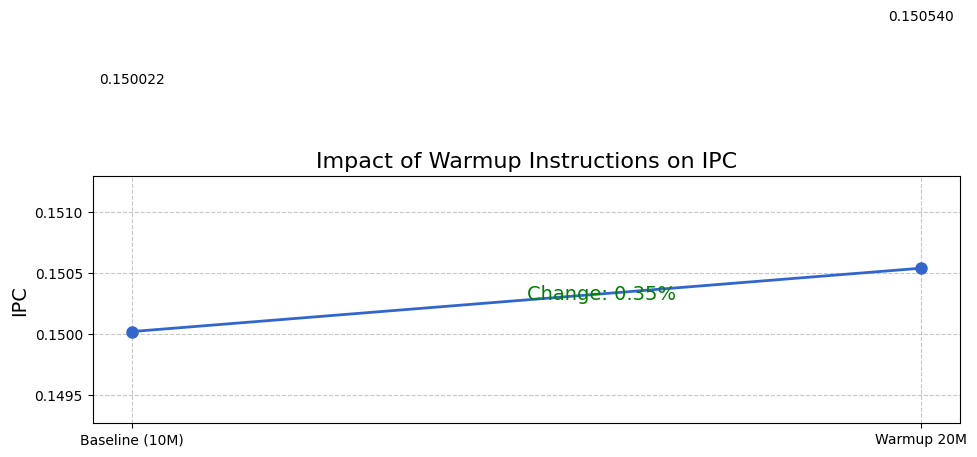

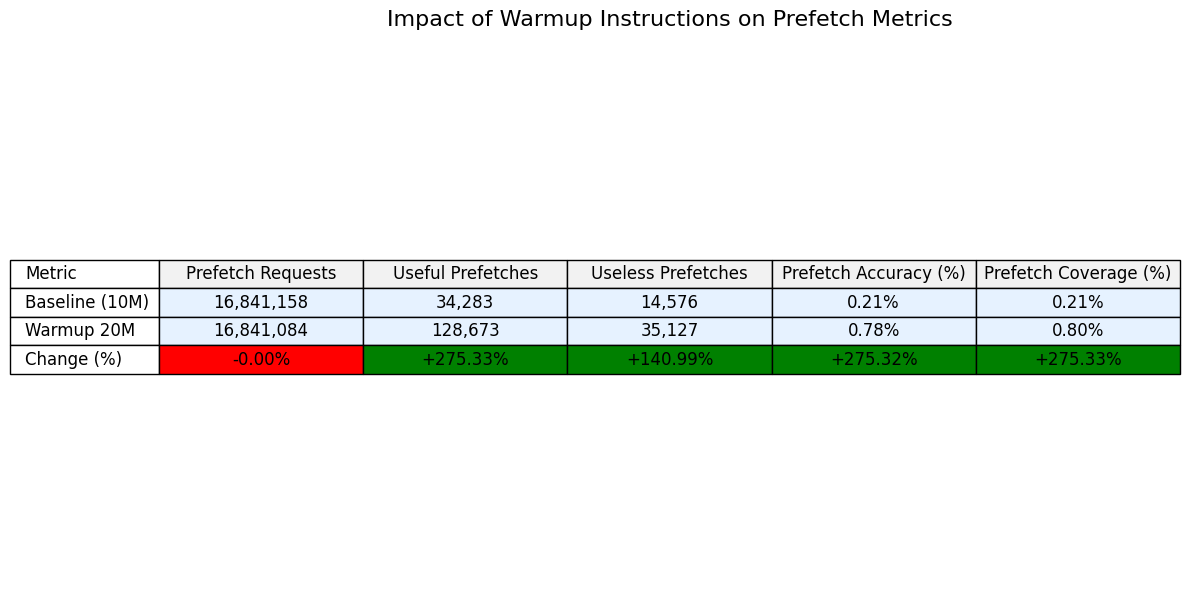

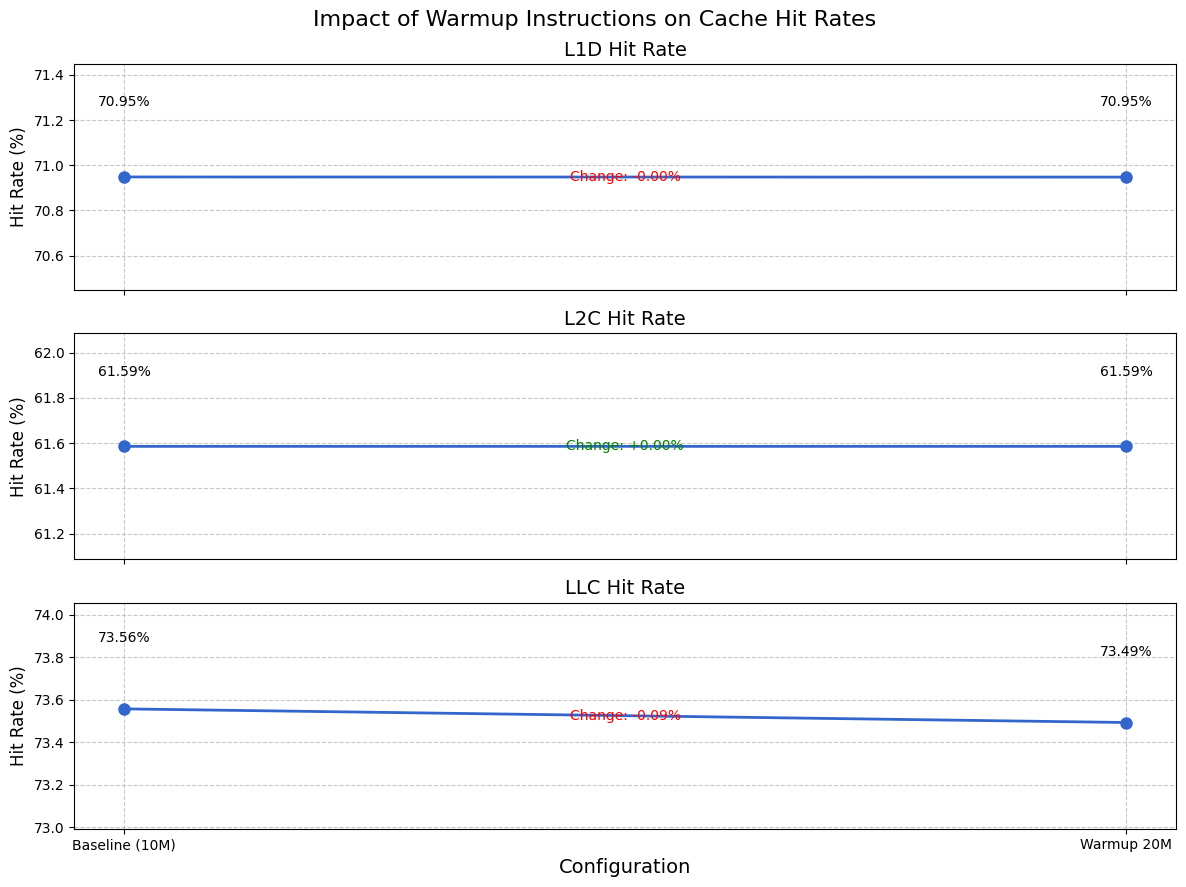

In [ ]:
def main():
    # File paths
    base_file = "/content/605.mcf-s1.trace.xz-from_file-base2.txt"
    warmup_file = "/content/605.mcf-s1.trace.xz-from_file_newSensitive_cluster4_success.txt"

    # Parse data
    base_data = parse_result_file(base_file)
    warmup_data = parse_result_file(warmup_file)

    # Perform sensitivity analysis
    analysis = analyze_sensitivity(base_data, warmup_data)

    # Print analysis results
    print("===== Sensitivity Analysis Results =====")
    print(f"IPC Change: {analysis['IPC_CHANGE']:.2f}%")
    print(f"Prefetch Requests Change: {analysis['PREFETCH_REQ_CHANGE']:.2f}%")
    print(f"Useful Prefetches Change: {analysis['PREFETCH_USEFUL_CHANGE']:.2f}%")
    print(f"Useless Prefetches Change: {analysis['PREFETCH_USELESS_CHANGE']:.2f}%")
    print(f"Prefetch Accuracy Change: {analysis['PREFETCH_ACCURACY_CHANGE']:.2f}%")
    print(f"Prefetch Coverage Change: {analysis['PREFETCH_COVERAGE_CHANGE']:.2f}%")
    print(f"LLC Hit Rate Change: {analysis['LLC_HIT_RATE_CHANGE']:.2f}%")
    print(f"DRAM Row Buffer Hit Rate Change: {analysis['DRAM_ROW_HIT_RATE_CHANGE']:.2f}%")
    print(f"Total Cycles Change: {analysis['TOTAL_CYCLES_CHANGE']:.2f}%")

    # Generate visualization charts
    plot_ipc_change(base_data, warmup_data, "ipc_change.png")
    plot_prefetch_metrics_table(base_data, warmup_data, "prefetch_metrics.png")
    plot_cache_hit_rates(base_data, warmup_data, "cache_hit_rates.png")

if __name__ == "__main__":
    main()

In [ ]:
def main():
    # File paths
    base_file = "/content/605.mcf-s0.trace.xz-hashed_perceptron-no-no-no-from_file-lru-1core.txt"
    warmup_file = "/content/605.mcf-s0.trace.xz-from_file warmup 20M敏感测试.txt"

    # Parse data
    base_data = parse_result_file(base_file)
    warmup_data = parse_result_file(warmup_file)

    # Perform sensitivity analysis
    analysis = analyze_sensitivity(base_data, warmup_data)

    # Print analysis results
    print("===== Sensitivity Analysis Results =====")
    print(f"IPC Change: {analysis['IPC_CHANGE']:.2f}%")
    print(f"Prefetch Requests Change: {analysis['PREFETCH_REQ_CHANGE']:.2f}%")
    print(f"Useful Prefetches Change: {analysis['PREFETCH_USEFUL_CHANGE']:.2f}%")
    print(f"Useless Prefetches Change: {analysis['PREFETCH_USELESS_CHANGE']:.2f}%")
    print(f"Prefetch Accuracy Change: {analysis['PREFETCH_ACCURACY_CHANGE']:.2f}%")
    print(f"Prefetch Coverage Change: {analysis['PREFETCH_COVERAGE_CHANGE']:.2f}%")
    print(f"LLC Hit Rate Change: {analysis['LLC_HIT_RATE_CHANGE']:.2f}%")
    print(f"DRAM Row Buffer Hit Rate Change: {analysis['DRAM_ROW_HIT_RATE_CHANGE']:.2f}%")
    print(f"Total Cycles Change: {analysis['TOTAL_CYCLES_CHANGE']:.2f}%")

if __name__ == "__main__":
    main()